In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sqlfunctions import get_datapunten_voor_model
import pickle

## Notities
Datapunten AI:
- omzet
- Beursgenoteerd of niet
- sector (nacebel code)
- aantal personeelsleden
- stedelijkheidsklasse
- site_aanwezig
- pdf_aanwezig

In [89]:
def get_initial_dataframe():
    data = get_datapunten_voor_model()
    dataframe = pd.DataFrame(data, columns=['ondernemingnr', 'omzet' ,'beursgenoteerd', 'sector', 'personeelsleden', 'site_aanwezig', 'pdf_aanwezig','stedelijkheidsklasse', 'score'])
    # dataframe = dataframe.groupby('ondernemingnr').agg({'omzet': 'first', 'beursgenoteerd': 'first', 'sector': 'first', 'personeelsleden': 'first', 'site_aanwezig': 'first', 'pdf_aanwezig': 'first', 'stedelijkheidsklasse': 'first','score': 'sum'}).reset_index()
    dataframe.drop("ondernemingnr", axis=1, inplace=True)
    return dataframe

In [90]:
dataframe = get_initial_dataframe()

In [91]:
print(dataframe["site_aanwezig"].value_counts())
print(dataframe["pdf_aanwezig"].value_counts())
# rows that both have a site and a pdf
len(dataframe[(dataframe['site_aanwezig'] == 1) & (dataframe['pdf_aanwezig'] == 1)])

1    27050
0    11955
Name: site_aanwezig, dtype: int64
1    37425
0     1580
Name: pdf_aanwezig, dtype: int64


25470

In [93]:
def transform_data(data):
    # TODO: we hebben originele data nodig om nieuwe data te transformeren
    data["sector"] = data["sector"].astype('category')
    # ordinal_encoder = OrdinalEncoder()
    # data["sector"] = ordinal_encoder.fit_transform(data[["sector"]])
    # print(ordinal_encoder.categories_)
    data["beursgenoteerd"] = data["beursgenoteerd"].astype('category')
    data["pdf_aanwezig"] = data["pdf_aanwezig"].astype('category')
    data["site_aanwezig"] = data["site_aanwezig"].astype('category')
    data["stedelijkheidsklasse"] = data["stedelijkheidsklasse"].astype('category')

    min_max_scaler = MinMaxScaler()
    data["omzet"] = min_max_scaler.fit_transform(data[["omzet"]])
    pickle.dump(min_max_scaler, open("min_max_scaler_omzet.sav", "wb"))

    min_max_scaler = MinMaxScaler()
    data["personeelsleden"] = min_max_scaler.fit_transform(data[["personeelsleden"]])
    pickle.dump(min_max_scaler, open("min_max_scaler_personeelsleden.sav", "wb"))
    
    data["personeelsleden"] = data["personeelsleden"].astype('float')
    

    return data


# api_data = [123412, 300, 9800, 12345, 1, 1, 0]
# dataframe = pd.DataFrame(data, columns=['omzet', 'beursgenoteerd', 'sector', 'personeelsleden', 'site_aanwezig', 'pdf_aanwezig', 'score'])
dataframe = transform_data(dataframe)
    # Pipeline([
    #     ('ordinal_encoder', OrdinalEncoder()),

# with open("final_model.sav", "rb") as file:
#     model = pickle.load(file)
    
# test_ = test_.drop("score", axis=1)
# test_ = test_.iloc[-1:]
# model.predict(test_)

In [45]:
dataframe.head()

,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,stedelijkheidsklasse,score
0,0.021860,False,378.0,0.070175,1,1,1,130.967646
1,0.029976,True,378.0,0.175439,1,1,0,6.791857
2,0.015178,False,13.0,0.438596,0,1,2,5.464225
3,0.014047,False,377.0,0.128655,1,1,0,43.966302
4,0.025320,False,378.0,0.242690,1,1,0,107.927458


In [67]:
# categorize sector
dataframe["sector"] = dataframe["sector"].astype('category')
# get amount of different sectors
sectors = dataframe["sector"].cat.categories
# how are the sectors distributed ?
dataframe["sector"].value_counts()

Goederenvervoer over de weg, m.u.v. verhuisbedrijven                             522
Detailhandel in auto's en lichte bestelwagens (kleiner of gelijk aan 3,5 ton)    342
Ontwerpen en programmeren van computerprogramma's                                288
Algemene bouw van residentiële gebouwen                                          257
Schrijnwerk                                                                      234
                                                                                ... 
Schilderen van civieltechnische werken                                             1
Vervaardiging van keramische tegels en plavuizen                                   1
Schoonheidsverzorging                                                              1
Vervaardiging van kantoorbenodigdheden van papier                                  1
Groothandel in levende dieren, m.u.v. levend vee                                   1
Name: sector, Length: 743, dtype: int64

In [72]:
# Data preprocessing


# encode sector
ordinal_encoder = OrdinalEncoder()
dataframe["sector"] = ordinal_encoder.fit_transform(dataframe[["sector"]])
dataframe["sector"] = dataframe["sector"].astype('category')
dataframe["beursgenoteerd"] = ordinal_encoder.fit_transform(dataframe[["beursgenoteerd"]])
dataframe["beursgenoteerd"] = dataframe["beursgenoteerd"].astype('category')
dataframe["site_aanwezig"] = dataframe["site_aanwezig"].astype('category')
dataframe["pdf_aanwezig"] = dataframe["pdf_aanwezig"].astype('category')

# Min Max scaling the omzet and personeelsleden
dataframe["omzet"] = MinMaxScaler().fit_transform(dataframe[["omzet"]])
dataframe["personeelsleden"] = MinMaxScaler().fit_transform(dataframe[["personeelsleden"]])
dataframe["personeelsleden"] = dataframe["personeelsleden"].astype(float)


In [10]:
dataframe

,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,stedelijkheidsklasse,score
0,0.021860,False,378.0,0.070175,1,1,1,130.967646
1,0.029976,True,378.0,0.175439,1,1,0,6.791857
2,0.015178,False,13.0,0.438596,0,1,2,5.464225
3,0.014047,False,377.0,0.128655,1,1,0,43.966302
4,0.025320,False,378.0,0.242690,1,1,0,107.927458
...,...,...,...,...,...,...,...,...
12997,0.001454,False,99.0,0.020468,0,1,0,6.944891
12998,0.000000,False,496.0,0.143275,1,0,1,1.153936
12999,0.056761,False,556.0,0.058480,0,1,2,5.118718
13000,0.009226,False,373.0,0.078947,1,1,2,10.366844


In [57]:
dataframe["personeelsleden"].value_counts()

0.017544    613
0.020468    599
0.026316    561
0.023392    516
0.029240    475
           ... 
0.014620      1
0.654971      1
0.733918      1
1.000000      1
0.649123      1
Name: personeelsleden, Length: 245, dtype: int64

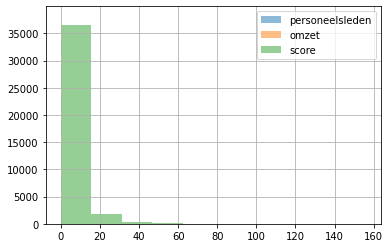

In [73]:
# Visualize data
# plot histogram
from matplotlib import pyplot as plt

dataframe["personeelsleden"].hist(label="personeelsleden", alpha=0.5)
dataframe["omzet"].hist(label="omzet", alpha=0.5)
dataframe["score"].hist(label="score", alpha=0.5)
plt.legend()



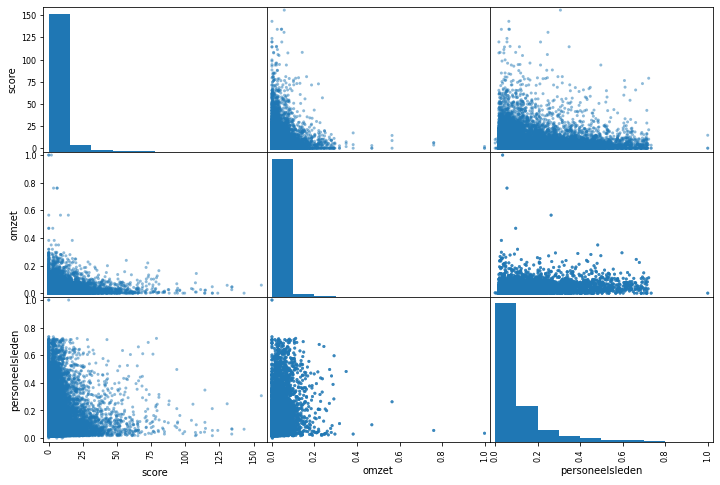

                    omzet  personeelsleden     score
omzet            1.000000         0.366415  0.101742
personeelsleden  0.366415         1.000000  0.099027
score            0.101742         0.099027  1.000000


In [74]:
# plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = dataframe.corr()
corr["score"].sort_values(ascending=False)
from pandas.plotting import scatter_matrix
attributes = ["score", "omzet", "personeelsleden", "beursgenoteerd"]
scatter_matrix(dataframe[attributes], figsize=(12, 8))
plt.show()


print(corr)



In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13002 entries, 0200065765 to 0899993714
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   omzet                   13002 non-null  float64 
 1   beursgenoteerd          13002 non-null  category
 2   sector                  13002 non-null  int32   
 3   personeelsleden         13002 non-null  int32   
 4   hoofdsteden_provincies  13002 non-null  int32   
 5   site_aanwezig           13002 non-null  category
 6   pdf_aanwezig            13002 non-null  category
 7   score                   13002 non-null  float64 
dtypes: category(3), float64(2), int32(3)
memory usage: 495.6+ KB


4.32690384240564

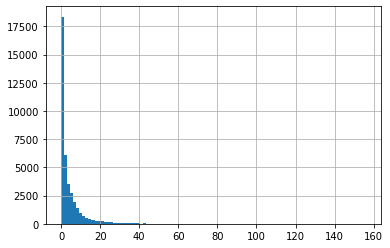

In [75]:
# plot distribution of score
dataframe["score"].describe()
# plot a detailed histogram
dataframe["score"].hist(bins=100)

# print 10 most common scores
dataframe["score"].value_counts().head(10)

# print mean score
dataframe["score"].mean()



![white box ml modellen](https://drek4537l1klr.cloudfront.net/thampi/HighResolutionFigures/figure_2-2.png)


In [76]:
# Model schrijven
# ! Kan pas gerund worden vanaf we alle data hebben
X = dataframe.drop(columns=["score"])
y = dataframe["score"]

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# y_train.info()
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 2266 to 15795
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   omzet                 35104 non-null  float64 
 1   beursgenoteerd        35104 non-null  category
 2   sector                35104 non-null  category
 3   personeelsleden       35104 non-null  float64 
 4   site_aanwezig         35104 non-null  category
 5   pdf_aanwezig          35104 non-null  category
 6   stedelijkheidsklasse  35104 non-null  category
dtypes: category(5), float64(2)
memory usage: 1.0 MB
<class 'pandas.core.series.Series'>
Int64Index: 3901 entries, 31438 to 22065
Series name: score
Non-Null Count  Dtype  
--------------  -----  
3901 non-null   float64
dtypes: float64(1)
memory usage: 61.0 KB


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TODO:
# - find out what score would be if we always predict the mean and predict 0 + compare with the scores of the models
# https://www.youtube.com/watch?v=L5OVCoAemAk
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
print("------------- Linear Regression --------------")

lin_reg = LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
lin_reg = GridSearchCV(lin_reg, parameters, scoring="neg_mean_squared_error", cv=5)
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
print(f"Best parameters: {lin_reg.best_params_}")
print(f"Best score: {lin_reg.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lin_reg)}")

------------- Linear Regression --------------
Best parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Best score: -63.037431688407366
MSE: 66.26050129420366


In [18]:


# SVR (Support Vector Regression)
from sklearn.svm import SVR
print("------------- SVR --------------")
svr_regressor = SVR(kernel='rbf', gamma="scale")
parameters = {'C': [1, 10, 20], 'epsilon': [0.1, 0.01, 0.001, 0.0001]}
svr_regressor = GridSearchCV(svr_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)
print(f"Best parameters: {svr_regressor.best_params_}")
print(f"Best score: {svr_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")



# BayesianRidge
from sklearn.linear_model import BayesianRidge
print("------------- BayesianRidge --------------")
bayesian_regressor = BayesianRidge()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
bayesian_regressor = GridSearchCV(bayesian_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
bayesian_regressor.fit(X_train, y_train)
y_pred_bay = bayesian_regressor.predict(X_test)
print(f"Best parameters: {bayesian_regressor.best_params_}")
print(f"Best score: {bayesian_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_bay)}")



------------- SVR --------------
Best parameters: {'C': 20, 'epsilon': 0.1}
Best score: -302.37904920116836
MSE: 316.22139120223216
------------- BayesianRidge --------------
Best parameters: {'alpha_1': 100, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 100}
Best score: -239.77928160755792
MSE: 257.4405945238632


In [78]:

# LassoLars
from sklearn.linear_model import LassoLars
print("------------- LassoLars --------------")
lassolars_regressor = LassoLars()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lassolars_regressor = GridSearchCV(lassolars_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
lassolars_regressor.fit(X_train, y_train)
y_pred_lassolars = lassolars_regressor.predict(X_test)
print(f"Best parameters: {lassolars_regressor.best_params_}")
print(f"Best score: {lassolars_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lassolars)}")

------------- LassoLars --------------
Best parameters: {'alpha': 0.1}
Best score: -66.73229523206487
MSE: 69.26397168897147


In [20]:
# ARDRegression
from sklearn.linear_model import ARDRegression
print("------------- ARDRegression --------------")
ard_regressor = ARDRegression()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
ard_regressor = GridSearchCV(ard_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ard_regressor.fit(X_train, y_train)
y_pred_ard = ard_regressor.predict(X_test)
print(f"Best parameters: {ard_regressor.best_params_}")
print(f"Best score: {ard_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ard)}")
print("------------- ARDRegression --------------")f


------------- ARDRegression --------------
Best parameters: {'alpha_1': 100, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 100}
Best score: -239.77754245903506
MSE: 257.4716380613389


In [18]:

# PassiveAggressiveRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
print("------------- PassiveAggressiveRegressor --------------")
passive_regressor = PassiveAggressiveRegressor()
parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'epsilon': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
passive_regressor = GridSearchCV(passive_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
passive_regressor.fit(X_train, y_train)
y_pred_pas = passive_regressor.predict(X_test)
print(f"Best parameters: {passive_regressor.best_params_}")
print(f"Best score: {passive_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_pas)}")


------------- PassiveAggressiveRegressor --------------
Best parameters: {'C': 0.1, 'epsilon': 1}
Best score: -0.0015840646966771455
MSE: 0.0014411840660125688


In [28]:

# TheilSenRegressor
from sklearn.linear_model import TheilSenRegressor
print("------------- TheilSenRegressor --------------")
theil_regressor = TheilSenRegressor()
parameters = {'max_subpopulation': [100, 500, 1000, 5000]}
theil_regressor = GridSearchCV(theil_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
theil_regressor.fit(X_train, y_train)
y_pred_seil = theil_regressor.predict(X_test)
print(f"Best parameters: {theil_regressor.best_params_}")
print(f"Best score: {theil_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_seil)}")



------------- TheilSenRegressor --------------
Best parameters: {'max_subpopulation': 1000}
Best score: -248.86399538690165
MSE: 271.1236378199631


In [33]:
# RANSACRegressor
from sklearn.linear_model import RANSACRegressor
print("------------- RANSACRegressor --------------")
ransac_regressor = RANSACRegressor()
parameters = {'min_samples': [1, 5, 10, 50, 100, 500, 1000], 'max_trials': [100, 500, 1000, 5000]}
ransac_regressor = GridSearchCV(ransac_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ransac_regressor.fit(X_train, y_train)
y_pred_ransac = ransac_regressor.predict(X_test)
print(f"Best parameters: {ransac_regressor.best_params_}")
print(f"Best score: {ransac_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ransac)}")

------------- RANSACRegressor --------------
Best parameters: {'max_trials': 500, 'min_samples': 1000}
Best score: -246.0978794101151
MSE: 263.4648095046217


In [32]:
# ridge regression
from sklearn.linear_model import Ridge
print("------------- Ridge regression --------------")
ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
print(f"Best parameters: {ridge_regressor.best_params_}")
print(f"Best score: {ridge_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")

# Lasso regression
from sklearn.linear_model import Lasso
print("------------- Lasso regression --------------")
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error", cv=5)
lasso_regressor.fit(X_train, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
y_pred_lasso = lasso_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")


------------- Ridge regression --------------
Best parameters: {'alpha': 0.5}
Best score: -239.77330520826112
MSE: 257.4407573953995
------------- Lasso regression --------------
{'alpha': 0.1}
-243.35376774547677
MSE: 261.7385916220957


In [79]:
from sklearn.metrics import mean_squared_error

# Random forest regression
from sklearn.ensemble import RandomForestRegressor
print("------------- Random forest regression --------------")
random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=5)
# parameters = {'n_estimators': [50, 100, 200, 500, 1000], 'max_depth': [2, 3, 5, 10, 15, 20, 30]}

# random_forest_regressor = GridSearchCV(random_forest_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
random_forest_regressor.fit(X_train, y_train)
# print(random_forest_regressor.best_params_)
# print(random_forest_regressor.best_score_)
y_pred_random = random_forest_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_random)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_random)}")
print(f"")

------------- Random forest regression --------------
MSE: 65.10399815725788
MAE: 4.422901069037893



{'max_depth': 5, 'n_estimators': 200}
-232.98217284814808


In [24]:
y_test.describe()

count    1301.000000
mean       12.988336
std        16.939520
min         0.000000
25%         3.168856
50%         7.643152
75%        14.766377
max       162.098438
Name: score, dtype: float64

In [81]:
# R2 scores berekenen voor elk model
from sklearn.metrics import r2_score
print("------------- R2 scores --------------")
print(f"R2 score linear regression: {r2_score(y_test, y_pred_lin_reg)}")
# print(f"R2 score ridge regression: {r2_score(y_test, y_pred_ridge)}")
# print(f"R2 score lasso regression: {r2_score(y_test, y_pred_lasso)}")
# print(f"R2 score passive aggressive regression: {r2_score(y_test, y_pred_pas)}")
# print(f"R2 score theil sen regression: {r2_score(y_test, y_pred_seil)}")
# print(f"R2 score ransac regression: {r2_score(y_test, y_pred_ransac)}")
print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


------------- R2 scores --------------
R2 score linear regression: 0.043331430078283995
R2 score random forest regression: 0.06002901280889772


In [37]:
from sklearn.metrics import r2_score

# print random forest feature importance
importances = random_forest_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_regressor.estimators_],
                axis=0) 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(f"-> {X_train.columns[indices[f]]}")


print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


Feature ranking:
1. feature 4 (0.492775)
-> site_aanwezig
2. feature 0 (0.303060)
-> omzet
3. feature 2 (0.092871)
-> sector
4. feature 6 (0.059101)
-> stedelijkheidsklasse
5. feature 3 (0.038998)
-> personeelsleden
6. feature 1 (0.012548)
-> beursgenoteerd
7. feature 5 (0.000645)
-> pdf_aanwezig
R2 score random forest regression: 0.12498674043482993


In [64]:
# get score if model predicted the mean of the training set score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print("------------- Mean score --------------")
mean_score = np.mean(y_train)
print(f"Mean score: {mean_score}")
y_pred_mean = np.full(y_test.shape, mean_score)
print(f"MSE: {mean_squared_error(y_test, y_pred_mean)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_mean)}")
print(f"R2 score: {r2_score(y_test, y_pred_mean)}")

# Model that always predicts 2.4
print("------------- Model that always predicts 2.4 --------------")
y_pred_24 = np.full(y_test.shape, 2.4)
print(f"MSE: {mean_squared_error(y_test, y_pred_24)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_24)}")
print(f"R2 score: {r2_score(y_test, y_pred_24)}")



------------- Mean score --------------
Mean score: 12.979493983175198
MSE: 286.7268529504561
MAE: 10.290656409015744
R2 score: -2.726747898584847e-07
------------- Model that always predicts 2.4 --------------
MSE: 398.8396362933567
MAE: 10.630869247854728
R2 score: -0.3910093907939163


In [82]:
# saving the best model
import pickle
filename = 'final_model.sav'
pickle.dump(random_forest_regressor, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

# make a prediction
new_data = X_test.iloc[0]
print([new_data])
print(loaded_model.predict([new_data]))
new_data = [0.00438, 0, 375.0, 0, 0, 1]
print(loaded_model.predict([new_data]))
# shape to 2d array (1, 6)
# loaded_model.predict(np.shape([[0.00438, False, 375.0, 0, 0, 1]], -1))


[omzet                     0.001831
beursgenoteerd            0.000000
sector                  485.000000
personeelsleden           0.023392
site_aanwezig             1.000000
pdf_aanwezig              1.000000
stedelijkheidsklasse      1.000000
Name: 31438, dtype: float64]
[3.51191143]


c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\jarno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 6 features, but RandomForestRegressor is expecting 7 features as input.

In [62]:
dataframe


,omzet,beursgenoteerd,sector,personeelsleden,site_aanwezig,pdf_aanwezig,score
0,0.021860,0.0,378.0,0.070175,1,1,0.131380
1,0.029976,1.0,378.0,0.175439,1,1,0.013276
2,0.015178,0.0,13.0,0.438596,0,1,0.003428
3,0.014047,0.0,377.0,0.128655,1,1,0.043966
4,0.025320,0.0,378.0,0.242690,1,1,0.107927
...,...,...,...,...,...,...,...
12997,0.001454,0.0,99.0,0.020468,0,1,0.002817
12998,0.000000,0.0,496.0,0.143275,1,0,0.004862
12999,0.056761,0.0,556.0,0.058480,0,1,0.005119
13000,0.009226,0.0,373.0,0.078947,1,1,0.016008


In [ ]:
# visualise how randomforestregressor works
from sklearn.tree import export_graphviz
import pydot
tree = random_forest_regressor.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_train.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
